# Fine tuning of DistilBERT - sentiment classifcation model using Imdb dataset.
This notebook fine-tunes **DistilBERT** on the **IMDb sentiment dataset** using **LoRA** for lightweight adaptation.
It then saves and zips the trained model so it can be used locally in our **LangGraph Self-Healing Classification DAG**.

## Step 1: Install Required Libraries
We install all dependencies: Hugging Face Transformers, Datasets, and PEFT (for LoRA).

In [1]:
!pip install -q transformers==4.44.0 datasets peft accelerate evaluate --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 69.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


##  Step 2: Import Libraries

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
import evaluate
import numpy as np

##  Step 3: Load IMDb Dataset

In [3]:
from datasets import load_dataset, concatenate_datasets

# Load IMDB train and test datasets
dataset = load_dataset("imdb")

# Combine train and test to get the full dataset
full_dataset = concatenate_datasets([dataset["train"], dataset["test"]])

# Split 70% train, 30% test
full_split = full_dataset.train_test_split(test_size=0.3, seed=42)

print(f"Training samples: {len(full_split['train'])}, Test samples: {len(full_split['test'])}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Training samples: 35000, Test samples: 15000


##  Step 4: Tokenize the Dataset

In [4]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenization function
def tokenize_function(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=256)

# Tokenize the full dataset split
tokenized_train = full_split["train"].map(tokenize_function, batched=True)
tokenized_test = full_split["test"].map(tokenize_function, batched=True)

print(f"Tokenized Training samples: {len(tokenized_train)}, Tokenized Test samples: {len(tokenized_test)}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Tokenized Training samples: 35000, Tokenized Test samples: 15000


##  Step 5: Prepare Model with LoRA

In [5]:
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=['q_lin', 'v_lin'],
    lora_dropout=0.1,
    bias='none',
    task_type='SEQ_CLS'
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 739,586 || all params: 67,694,596 || trainable%: 1.0925


##  Step 6: Define Metrics and Trainer

In [6]:
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer

# --- Metrics ---
accuracy = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

# --- Training configuration for recruiter-friendly plots ---
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3, # Keep this for full dataset
    max_steps=4000, # Specify total training steps
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,            # log every 100 steps
    evaluation_strategy="steps",  # periodic evaluation
    eval_steps=500,               # evaluate every 500 steps
    save_strategy="steps",        # save checkpoint every 500 steps
    save_steps=500,
    save_total_limit=1,
    report_to="none", # Disable wandb logging
    load_best_model_at_end=True,  # best model according to accuracy
    metric_for_best_model="accuracy"
)

# --- Trainer initialization (do NOT start training yet) ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


##  Step 7: Train the Model

In [7]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
500,0.349000,0.345258,0.857267
1000,0.356400,0.305739,0.872933
1500,0.334100,0.301542,0.878200
2000,0.308100,0.291595,0.881333
2500,0.299900,0.295953,0.882733
3000,0.298900,0.286969,0.885200
3500,0.282300,0.292456,0.885733
4000,0.314400,0.288119,0.885667


TrainOutput(global_step=4000, training_loss=0.3297350564002991, metrics={'train_runtime': 1510.8594, 'train_samples_per_second': 21.18, 'train_steps_per_second': 2.647, 'total_flos': 2155830509568000.0, 'train_loss': 0.3297350564002991, 'epoch': 0.9142857142857143})

##  Step 8: Evaluate Model Performance

 Final Accuracy: 88.57%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


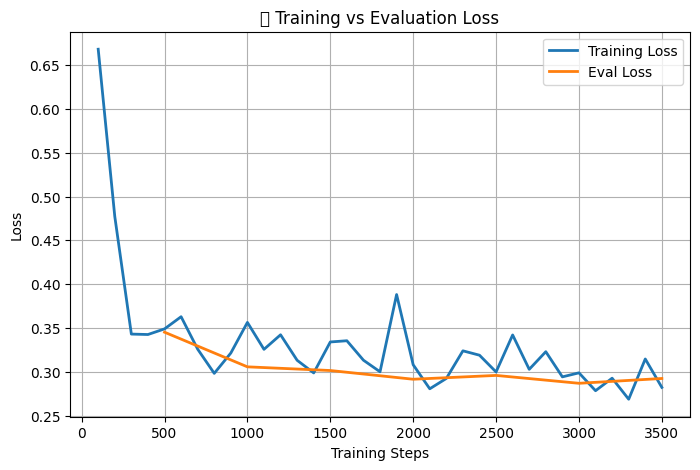

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


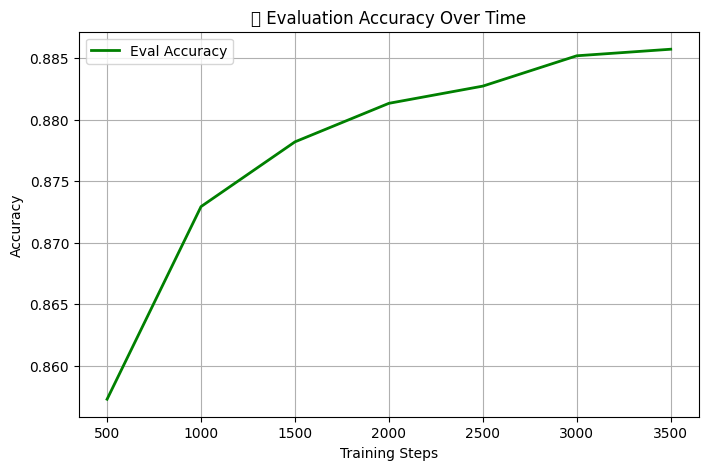

In [11]:
#  Install matplotlib (for visual plots)
!pip install -q matplotlib

import matplotlib.pyplot as plt
import json, os

# Evaluate model on test data
results = trainer.evaluate()
print(f" Final Accuracy: {results['eval_accuracy']*100:.2f}%")

# --- Visualize Training Metrics ---
state_path = os.path.join(training_args.output_dir, "/content/results/checkpoint-3500/trainer_state.json")

if os.path.exists(state_path):
    with open(state_path, "r") as f:
        logs = json.load(f)

    log_history = logs.get("log_history", [])
    train_steps, train_losses = [], []
    eval_steps, eval_losses, eval_acc = [], [], []

    for entry in log_history:
        if "loss" in entry and "learning_rate" in entry:
            train_steps.append(entry["step"])
            train_losses.append(entry["loss"])
        if "eval_loss" in entry:
            eval_steps.append(entry["step"])
            eval_losses.append(entry["eval_loss"])
            eval_acc.append(entry.get("eval_accuracy", None))

    # 📉 Plot Training vs Evaluation Loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_steps, train_losses, label="Training Loss", linewidth=2)
    plt.plot(eval_steps, eval_losses, label="Eval Loss", linewidth=2)
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("📉 Training vs Evaluation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 📈 Plot Evaluation Accuracy Curve (if available)
    if any(eval_acc):
        plt.figure(figsize=(8, 5))
        plt.plot(eval_steps, eval_acc, label="Eval Accuracy", color="green", linewidth=2)
        plt.xlabel("Training Steps")
        plt.ylabel("Accuracy")
        plt.title("📈 Evaluation Accuracy Over Time")
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print(" No trainer_state.json found. Loss curves not available.")


## Step 9b: Merge LoRA weights with Base Model and Save
This step merges the trained LoRA adapter weights with the original DistilBERT base model to create a single, complete fine-tuned model.

In [12]:
from peft import PeftModel
import os

# Load the base model again
base_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Load the LoRA adapter weights
lora_model_dir = '/content/results/checkpoint-3500'
model = PeftModel.from_pretrained(base_model, lora_model_dir)

# Merge the LoRA weights with the base model
merged_model = model.merge_and_unload()

# Define the directory to save the merged model
merged_model_dir = '/content/my_merged_model'

# Save the merged model and tokenizer
merged_model.save_pretrained(merged_model_dir)
tokenizer.save_pretrained(merged_model_dir)

print(f"Merged model saved to: {merged_model_dir}")

# Zip the merged model
!zip -r /content/my_merged_model.zip /content/my_merged_model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Merged model saved to: /content/my_merged_model
  adding: content/my_merged_model/ (stored 0%)
  adding: content/my_merged_model/vocab.txt (deflated 53%)
  adding: content/my_merged_model/model.safetensors (deflated 8%)
  adding: content/my_merged_model/config.json (deflated 44%)
  adding: content/my_merged_model/tokenizer.json (deflated 71%)
  adding: content/my_merged_model/tokenizer_config.json (deflated 76%)
  adding: content/my_merged_model/special_tokens_map.json (deflated 42%)


## Step 9c: Download the Merged Model

In [13]:
from google.colab import files
files.download('/content/my_merged_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##  Notebook Summary
- Fine-tuned **DistilBERT** on IMDb dataset
- Used **LoRA** for faster, lighter training
- Exported model for offline use in **LangGraph DAG**
- Recruiter-friendly structure with clear comments